# PCA and k-means

## Setting up

In [1]:
import time

# numpy and scipy libraries
import numpy as np
from scipy import stats

# matplotlib libraries
import matplotlib.pyplot as plt
import collections

In [2]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/My Drive/M146/HW4')


In [4]:
import util
from util import *

## Point, Cluster and Set of Clusters classes

In [5]:
######################################################################
# classes
######################################################################

class Point(object) :

    def __init__(self, name, label, attrs) :
        """
        A data point.

        Attributes
        --------------------
            name  -- string, name
            label -- string, label
            attrs -- numpy arrray of shape (d, ) where d is the number of features
        """

        self.name = name
        self.label = label
        self.attrs = attrs


    #============================================================
    # utilities
    #============================================================

    def distance(self, other) :
        """
        Return Euclidean distance of this point with other point.

        Parameters
        --------------------
            other -- Point, point to which we are measuring distance

        Returns
        --------------------
            dist  -- float, Euclidean distance
        """
        # Euclidean distance metric
        return np.linalg.norm(self.attrs-other.attrs)


    def __str__(self) :
        """
        Return string representation.
        """
        return "%s : (%s, %s)" % (self.name, str(self.attrs), self.label)

In [6]:
class Cluster(object) :

    def __init__(self, points) :
        """
        A cluster (set of points).

        Attributes
        --------------------
            points -- list of Points, cluster elements
        """
        self.points = points


    def __str__(self) :
        """
        Return string representation.
        """
        s = ""
        for point in self.points :
            s += str(point)
        return s

    #============================================================
    # utilities
    #============================================================

    def purity(self) :
        """
        Compute cluster purity.

        Returns
        --------------------
            n           -- int, number of points in this cluster
            num_correct -- int, number of points in this cluster
                                with label equal to most common label in cluster
        """
        labels = []
        for p in self.points :
            labels.append(p.label)

        cluster_label, count = stats.mode(labels)
        return len(labels), np.float64(count)


    def centroid(self) :
        """
        Compute centroid of this cluster.

        Returns
        --------------------
            centroid -- Point, centroid of cluster
        """

        # set the centroid label to any value (e.g. the most common label in this cluster)

        labels = []
        attributes=[]
        for p in self.points :
            labels.append(p.label)
            attributes.append(p.attrs)

        most_common_label, count = stats.mode(labels)
        centroid_attr=np.mean(attributes,axis=0)
        centroid=Point("centroid",most_common_label,centroid_attr)

        return centroid



    def medoid(self) :
        """
        Compute medoid of this cluster, that is, the point in this cluster
        that is closest to all other points in this cluster.

        Returns
        --------------------
            medoid -- Point, medoid of this cluster
        """

        J_values=[]
        for p_1 in self.points :
          sum=0
          for p_2 in self.points:
            sum=sum+ pow(p_1.distance(p_2),2)
          J_values.append(sum)

        medoid_index= J_values.index(min(J_values))
        medoid=self.points[medoid_index]


        return medoid


    def equivalent(self, other) :
        """
        Determine whether this cluster is equivalent to other cluster.
        Two clusters are equivalent if they contain the same set of points
        (not the same actual Point objects but the same geometric locations).

        Parameters
        --------------------
            other -- Cluster, cluster to which we are comparing this cluster

        Returns
        --------------------
            flag  -- bool, True if both clusters are equivalent or False otherwise
        """

        if len(self.points) != len(other.points) :
            return False

        matched = []
        for point1 in self.points :
            for point2 in other.points :
                if point1.distance(point2) == 0 and point2 not in matched :
                    matched.append(point2)
        return len(matched) == len(self.points)

In [7]:
class ClusterSet(object):

    def __init__(self) :
        """
        A cluster set (set of clusters).

        Parameters
        --------------------
            members -- list of Clusters, clusters that make up this set
        """
        self.members = []


    #============================================================
    # utilities
    #============================================================

    def centroids(self) :
        """
        Return centroids of each cluster in this cluster set.

        Returns
        --------------------
            centroids -- list of Points, centroids of each cluster in this cluster set
        """


        centroids=[]
        for cluster in self.members:
          centroids.append(cluster.centroid())

        return centroids




    def medoids(self) :
        """
        Return medoids of each cluster in this cluster set.

        Returns
        --------------------
            medoids -- list of Points, medoids of each cluster in this cluster set
        """

        medoids=[]
        for cluster in self.members:
          medoids.append(cluster.medoid())

        return medoids



    def score(self) :
        """
        Compute average purity across clusters in this cluster set.

        Returns
        --------------------
            score -- float, average purity
        """

        total_correct = 0
        total = 0
        for c in self.members :
            n, n_correct = c.purity()
            total += n
            total_correct += n_correct
        return total_correct / float(total)


    def equivalent(self, other) :
        """
        Determine whether this cluster set is equivalent to other cluster set.
        Two cluster sets are equivalent if they contain the same set of clusters
        (as computed by Cluster.equivalent(...)).

        Parameters
        --------------------
            other -- ClusterSet, cluster set to which we are comparing this cluster set

        Returns
        --------------------
            flag  -- bool, True if both cluster sets are equivalent or False otherwise
        """

        if len(self.members) != len(other.members):
            return False

        matched = []
        for cluster1 in self.members :
            for cluster2 in other.members :
                if cluster1.equivalent(cluster2) and cluster2 not in matched:
                    matched.append(cluster2)
        return len(matched) == len(self.members)


    #============================================================
    # manipulation
    #============================================================

    def add(self, cluster):
        """
        Add cluster to this cluster set (only if it does not already exist).

        If the cluster is already in this cluster set, raise a ValueError.

        Parameters
        --------------------
            cluster -- Cluster, cluster to add
        """

        if cluster in self.members :
            raise ValueError

        self.members.append(cluster)

## k-means and k-medoids algorithms

In [8]:
# @title Default title text
######################################################################
# k-means and k-medoids
######################################################################

def random_init(points, k) :
    """
    Randomly select k unique elements from points to be initial cluster centers.

    Parameters
    --------------------
        points         -- list of Points, dataset
        k              -- int, number of clusters

    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    initial_points=np.random.choice(points,k,replace=False)

    return initial_points



def cheat_init(points) :
    """
    Initialize clusters by cheating!

    Details
    - Let k be number of unique labels in dataset.
    - Group points into k clusters based on label (i.e. class) information.
    - Return medoid of each cluster as initial centers.

    Parameters
    --------------------
        points         -- list of Points, dataset

    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """

    unique_labels=np.unique([p.label for p in points])
    initial_points=[]

    for label in unique_labels:
      cluster_points=[]
      for p in points:
        if p.label==label:
          cluster_points.append(p)
      initial_points.append(Cluster(cluster_points).medoid())

    return initial_points

def kAverages(points, k, average, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.

    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        average -- method of ClusterSet
                   determines how to calculate average of points in cluster
                   allowable: ClusterSet.centroids, ClusterSet.medoids
        init    -- string, method of initialization
                   allowable:
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm

    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """


    #initalizes clustersets and iteration count
    k_clusters=ClusterSet()
    k_clusters_old=ClusterSet()
    iter=1

    #updates if the old and new clustersets are different or if this
    #is the first iteration
    while iter==1 or not k_clusters_old.equivalent(k_clusters):

      if iter==1:
        #initializes prototypes using the init functions
        if init=="random":
          prototypes=random_init(points,k)
        else:
          prototypes=cheat_init(points)
      else:
        #updates prototypes using the most recent clusterset
        prototypes=average(k_clusters)

        #stores the most recentcluster set as an "old" clusterset
        #this helps us check the while condition
        k_clusters_old=k_clusters
        k_clusters=ClusterSet()

      for prototype_index in range(len(prototypes)):
        #for each prototype, calculate all points that are closest to it
        #then create a cluster with these points and add it to the clusterset

        cluster_points=[]
        for p in points:

          cluster_distances=[pow(p.distance(other),2) for other in prototypes]
          closest_cluster_index=cluster_distances.index(min(cluster_distances))

          if closest_cluster_index==prototype_index:
            cluster_points.append(p)

        k_clusters.add(Cluster(cluster_points))

      if plot==True:
        plot_clusters(k_clusters,f"Iteration {iter}",average)

      iter+=1

    return k_clusters



def kMeans(points, k, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.

    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        init    -- string, method of initialization
                   allowable:
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm

    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """


    k_clusters=kAverages(points,k,ClusterSet.centroids,init,plot)
    return k_clusters



def kMedoids(points, k, init='random', plot=False) :
    """
    Cluster points in k clusters using k-medoids clustering.
    See kMeans(...).
    """

    k_clusters=kAverages(points,k,ClusterSet.medoids,init,plot)
    return k_clusters



## Utilities

In [9]:
######################################################################
# helper functions
######################################################################

def build_face_image_points(X, y) :
    """
    Translate images to (labeled) points.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), features (each row is one image)
        y     -- numpy array of shape (n,), targets

    Returns
    --------------------
        point -- list of Points, dataset (one point for each image)
    """

    n,d = X.shape

    images = collections.defaultdict(list) # key = class, val = list of images with this class
    for i in range(n) :
        images[y[i]].append(X[i,:])

    points = []
    for face in images :
        count = 0
        for im in images[face] :
            points.append(Point(str(face) + '_' + str(count), face, im))
            count += 1

    return points


def plot_clusters(clusters, title, average) :
    """
    Plot clusters along with average points of each cluster.

    Parameters
    --------------------
        clusters -- ClusterSet, clusters to plot
        title    -- string, plot title
        average  -- method of ClusterSet
                    determines how to calculate average of points in cluster
                    allowable: ClusterSet.centroids, ClusterSet.medoids
    """

    plt.figure()
    np.random.seed(20)
    label = 0
    colors = {}
    centroids = average(clusters)
    for c in centroids :
        coord = c.attrs
        plt.plot(coord[0],coord[1], 'ok', markersize=12)
    for cluster in clusters.members :
        label += 1
        colors[label] = np.random.rand(3,)
        for point in cluster.points :
            coord = point.attrs
            plt.plot(coord[0], coord[1], 'o', color=colors[label])
    plt.title(title)
    plt.show()


def generate_points_2d(N, seed=1234) :
    """
    Generate toy dataset of 3 clusters each with N points.

    Parameters
    --------------------
        N      -- int, number of points to generate per cluster
        seed   -- random seed

    Returns
    --------------------
        points -- list of Points, dataset
    """
    np.random.seed(seed)

    mu = [[0,0.5], [1,1], [2,0.5]]
    sigma = [[0.1,0.1], [0.25,0.25], [0.15,0.15]]

    label = 0
    points = []
    for m,s in zip(mu, sigma) :
        label += 1
        for i in range(N) :
            x = random_sample_2d(m, s)
            points.append(Point(str(label)+'_'+str(i), label, x))

    return points

## Main function

Total dataset size:
	num_samples: 1867
	num_features: 1850
	num_classes: 19
		 kMeans


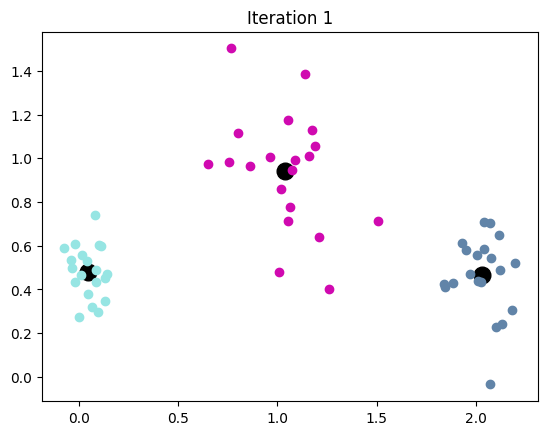

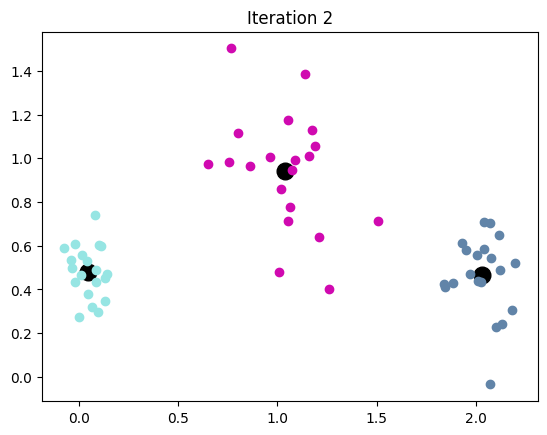



		 kMedoids


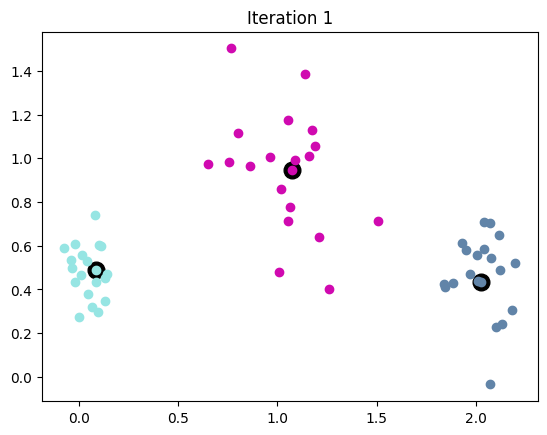

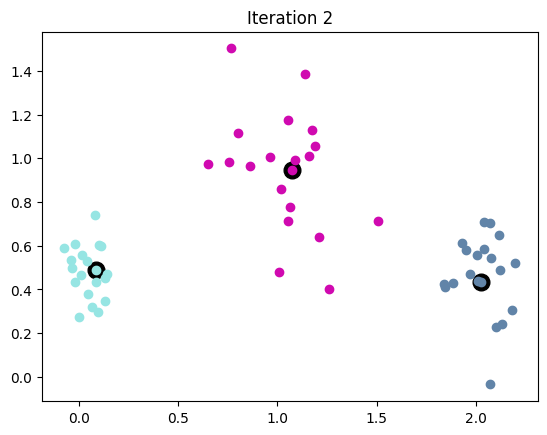

kMeans

	Average Purity: 0.5831250000000001

	Min Purity: 0.51875

	Max Purity: 0.6875

	Average Time: 0.17770392894744874

	Min Time: 0.11811161041259766

	Max Time: 0.29265904426574707

kMedoids

	Average Purity: 0.646875

	Min Purity: 0.59375

	Max Purity: 0.75625

	Average Time: 0.16589617729187012

	Min Time: 0.12479043006896973

	Max Time: 0.24152612686157227



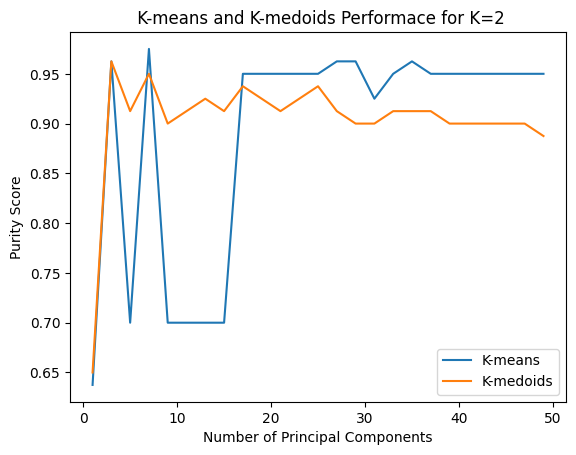

Most Discriminative: {'pair': [0, 13], 'purity': 1.0}
Most Similar: {'pair': [0, 11], 'purity': 0.5}


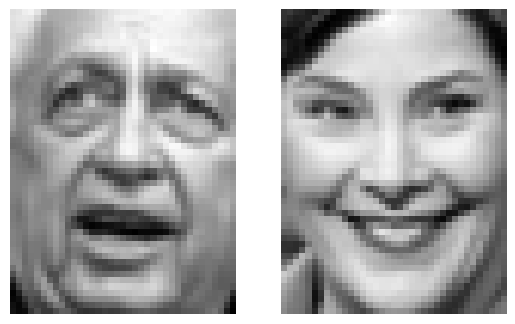

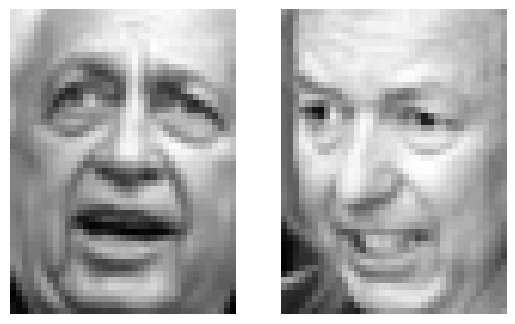

In [10]:
######################################################################
# main
######################################################################

def main() :
    X,y=get_lfw_data()




    print("\t\t kMeans")
    kMeans(generate_points_2d(20),3,init="cheat",plot=True)

    print("\n\n\t\t kMedoids")
    kMedoids(generate_points_2d(20),2,init="cheat",plot=True)


    np.random.seed(1234)
    X1, y1 = util.limit_pics(X, y, [4, 6, 13, 16], 40)
    points = build_face_image_points(X1, y1)
    means_times=[]
    means_scores=[]
    medoids_times=[]
    medoids_scores=[]

    for i in range(10):
      start_time=time.time()
      score=kMeans(points,4,init="random").score()
      end_time=time.time()
      means_scores.append(score)
      means_times.append(end_time-start_time)

      start_time=time.time()
      score=kMedoids(points,4,init="random").score()
      medoids_scores.append(score)
      end_time=time.time()
      medoids_scores.append(score)
      medoids_times.append(end_time-start_time)

    print(f"kMeans\n")
    print(f"\tAverage Purity: {np.average(means_scores)}\n")
    print(f"\tMin Purity: {min(means_scores)}\n")
    print(f"\tMax Purity: {max(means_scores)}\n")
    print(f"\tAverage Time: {np.average(means_times)}\n")
    print(f"\tMin Time: {min(means_times)}\n")
    print(f"\tMax Time: {max(means_times)}\n")

    print(f"kMedoids\n")
    print(f"\tAverage Purity: {np.average(medoids_scores)}\n")
    print(f"\tMin Purity: {min(medoids_scores)}\n")
    print(f"\tMax Purity: {max(medoids_scores)}\n")
    print(f"\tAverage Time: {np.average(medoids_times)}\n")
    print(f"\tMin Time: {min(medoids_times)}\n")
    print(f"\tMax Time: {max(medoids_times)}\n")


    # explore effect of lower-dimensional representations on clustering performance
    np.random.seed(1234)

    means_scores=[]
    medoids_scores=[]
    ls=[i for i in range(1,50,2)]

    X1,y1=util.limit_pics(X,y,[4,13],40)  #new dataset only with individuals 4 and 13
    U,mu=util.PCA(X1)                     #PCA for entire image set

    for l in ls:
      Z,Ul= util.apply_PCA_from_Eig(X1,U,l,mu)   #project C into lower dimension
      face_points=build_face_image_points(Z, y1)

      #calculate scores
      means_scores.append(kMeans(face_points,2,init="cheat").score())
      medoids_scores.append(kMedoids(face_points,2,init="cheat").score())

    plt.plot(ls,means_scores,label="K-means")
    plt.plot(ls,medoids_scores,label="K-medoids")
    plt.title(" K-means and K-medoids Performace for K=2")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Purity Score")
    plt.legend()
    plt.show()

    # determine ``most discriminative'' and ``least discriminative'' pairs of images
    np.random.seed(1234)

    labels=np.unique(y)
    results=[]

    for i,label_1 in enumerate(labels):
      for label_2 in labels[i+1:]:
        X1,y1=util.limit_pics(X,y,[label_1,label_2],40)  #creates new dataset with only two labels
        U,mu=util.PCA(X1)                                #PCA for entire image set
        Z,Ul= util.apply_PCA_from_Eig(X1,U,50,mu)        #project into lower dimension
        face_points=build_face_image_points(Z, y1)

        score=kMeans(face_points,2,init="cheat").score()
        results.append({'pair':[label_1,label_2],"purity":score})
        #creates a dict with pair evaluated and score

    max_purity = max(results, key=lambda x:x['purity']) #finds pair that scored best
    min_purity = min(results, key=lambda x:x['purity']) #finds pair that scored worst

    print(f"Most Discriminative: {max_purity}\nMost Similar: {min_purity}")
    util.plot_representative_images (X, y, max_purity["pair"], title = 'Most Discriminative')
    util.plot_representative_images (X, y, min_purity["pair"], title = 'Most Similar')


if __name__ == "__main__" :
    main()